In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

from dbfread import DBF
from glob import glob
from tqdm import tqdm
import os 

import geopandas as gpd
import rasterio
import rasterio.features as features
from rasterio.plot import show
from shapely.geometry import Polygon

from osgeo import ogr
from osgeo import osr
from osgeo import gdal

import itertools
import rasterio
from shapely.geometry import box
import geopandas as gpd
from rasterio.enums import MergeAlg

/home/jupyter-peta_admin/.local/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
kdprov = '19'

In [3]:
from osgeo import gdal, ogr, osr

In [4]:
import itertools
import rasterio
from shapely.geometry import box
import geopandas as gpd
with rasterio.open('data/input/GHSL Data/2020/prov/2020_'+kdprov+'.tif') as dataset:
    data = dataset.read(1)

    t = dataset.transform

    move_x = t[0]
    move_y = t[4]

    height = dataset.height
    width = dataset.width 

    polygons = []
    indices = list(itertools.product(range(width), range(height)))
    data_list = []
    
    for x,y in indices:
        x_min, y_max = t * (x,y)
        x_max = x_min + move_x
        y_min = y_max + move_y
        polygons.append(box(x_min, y_min, x_max, y_max))
        data_list.append(data[y,x])

In [5]:
gdf = gpd.GeoDataFrame(data=data_list, geometry=polygons, columns=['value'])

In [6]:
gdf.query('(value>=0)and(value<=10000)').to_file("data/input/GHSL Data/2020/gpkg/ghs_built_"+kdprov+"_nonzero.shp")

In [7]:
# import gpkg desa & filter

vector = gpd.read_file(r"data/input/Master_Data/DESA_20201_BYINDO.gpkg").query('kdprov==@kdprov').to_crs("ESRI:54009")
raster = rasterio.open(r"/vsigs/bps-gcp-bucket/Degree of Urbanisation/GHSL data/2020/prov/2020_"+kdprov+".tif")
geom = [shapes for shapes in vector.geometry]
# vector['iddesa'] = vector.iddesa.astype(np.int32)
vector['id'] = range(0,len(vector))

<AxesSubplot:>

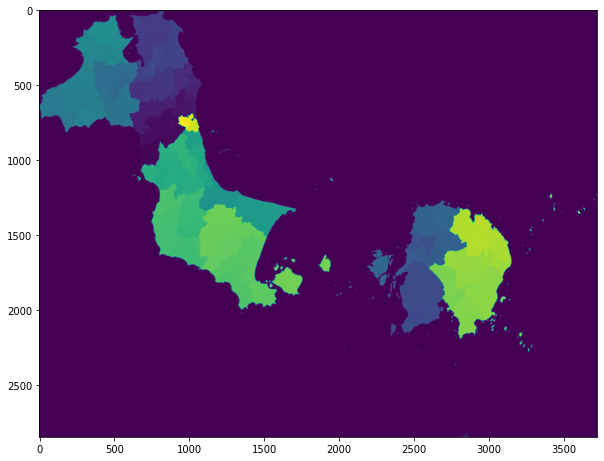

In [8]:
# create tuples of geometry, value pairs, where value is the attribute value you want to burn
geom_value = ((geom,value) for geom, value in zip(vector.geometry, vector['id']))
# Rasterize vector using the shape and transform of the raster
#rasterized = features.rasterize(geom_value,
#                                out_shape = raster.shape,
#                                fill = -5,
#                                out = None,
#                                transform = raster.transform,
#                                all_touched = False,
#                                default_value = 1,
#                                dtype = np.int32)

rasterized = features.rasterize(geom_value,
                                out_shape = raster.shape,
                                transform = raster.transform,
                                all_touched = True,
                                fill = -5,   # background value
                                default_value = 1,
                                dtype = np.int32)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax)
#plt.gca().invert_yaxis()

In [9]:
# rasterization polygon desa

with rasterio.open(
        "data/temp/rasterized_vector.tif", "w",
        driver = "GTiff",
        transform = raster.transform,
        dtype = rasterio.int32,
        count = 1,
        width = raster.width,
        height = raster.height) as dst:
    dst.write(rasterized, indexes = 1)

# polygonize polygon desa

raster_src = gdal.Open(r'data/temp/rasterized_vector.tif')
band = raster_src.GetRasterBand(1) 

drv = ogr.GetDriverByName('ESRI Shapefile')
outfile = drv.CreateDataSource(r'data/temp/polygonizedRaster.shp') 
outlayer = outfile.CreateLayer('polygonized raster', srs = None )
newField = ogr.FieldDefn('DN', ogr.OFTReal)
outlayer.CreateField(newField)

gdal.Polygonize(band, None, outlayer, 0, [])
outfile = None

raster = None
raster_src = None

desa = gpd.read_file(r'data/temp/polygonizedRaster.shp')
desa = desa.loc[desa.DN>0].merge(vector[['id','iddesa']], 
                                 left_on = "DN", right_on = "id", how="left").dissolve(by="iddesa").reset_index()
desa.crs='ESRI:54009'
desa.to_file("data/input/desa_rasterize_"+kdprov+".gpkg", driver="GPKG")

In [10]:
# import ruta

data_ruta=pd.read_csv('data/input/Master_Data/pop_desa.csv',sep=',')
data_ruta.iddesa=data_ruta.iddesa.astype(str)
#data_ruta['iddesa'] = [x[0:10] for x in data_ruta.KODE_SLS]
data_ruta['idprov'] = [x[0:2] for x in data_ruta.iddesa]

data_ruta = data_ruta.loc[data_ruta.idprov.isin([kdprov])]

# join penduduk & polygon desa

data_ruta_desa = pd.DataFrame(data_ruta.groupby("iddesa").pop2020.sum()).reset_index()
desa = desa.merge(data_ruta_desa, how="inner")
desa.set_crs('ESRI:54009').to_file("data/output/0_raster_data_desa/desa_pend_rasterize_"+kdprov+".gpkg", driver="GPKG")

In [11]:
print("Ada di Peta. tidak di Hasil SP : "+str(desa[~desa.iddesa.isin(data_ruta.iddesa)].shape[0]))
print("Ada di Hasil SP. tidak di Peta : "+str(data_ruta[~data_ruta.iddesa.isin(desa.iddesa)].shape[0]))

Ada di Peta. tidak di Hasil SP : 0
Ada di Hasil SP. tidak di Peta : 2


In [12]:
desa.iddesa

0      1901070002
1      1901070003
2      1901070004
3      1901070005
4      1901070006
          ...    
384    1971041002
385    1971041003
386    1971041004
387    1971041005
388    1971041006
Name: iddesa, Length: 389, dtype: object

In [13]:
data_ruta[~data_ruta.iddesa.isin(desa.iddesa)]

,iddesa,pop2020,idprov
24701,1972023004,2240,19
24702,1901070001,5666,19
